## Using Bayesian Models to Estimate the Redshift of Galaxies from Simulated Magnitudes in the LSST Bands

### Abstract
This work explores the use of simulated magnitudes in the LSST bands (u, g, r, i, z, y) to estimate the redshift of galaxies through Bayesian models.

### Motivation
Both simulated magnitudes and redshift estimates (especially photometric redshifts) are subject to uncertainties. The Bayesian approach allows these uncertainties to be explicitly modeled, providing probabilistic estimates instead of point values.

Bayesian models also allow the incorporation of prior astrophysical knowledge, such as expected redshift distributions or known relationships between colors and redshift.

### Data Source
Simulations based on data from the Sloan Digital Sky Survey (SDSS) Data Release SD17.  
🔗 [Notebook on Kaggle](https://www.kaggle.com/code/waelmoham6d/stellar-classification/notebook)


### Data preprocessing:

In [1]:
import pandas as pd

df = pd.read_csv('../orientation/star_classification.csv')
print("DataFrame columns:")
print(df.columns)
print("\nUnique values in the 'class' column:")
print(df['class'].unique())
print("\nData types of each column:")
print(df.dtypes)

DataFrame columns:
Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

Unique values in the 'class' column:
['GALAXY' 'QSO' 'STAR']

Data types of each column:
obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class           object
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object


In [2]:
df_galaxies = df[df['class'] == 'GALAXY']
print(df_galaxies.shape)

(59445, 18)


In [3]:
df_galaxies_selected = df_galaxies[['u', 'g', 'r', 'i', 'z', 'redshift']]
df_galaxies_selected.head()

,u,g,r,i,z,redshift
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123


In [4]:
mask_valid = (
    df_galaxies_selected[['u', 'g', 'r', 'i', 'z', 'redshift']].notna().all(axis=1) &
    (df_galaxies_selected[['u', 'g', 'r', 'i', 'z', 'redshift']] >= 0).all(axis=1)
)
df_galaxies_selected_clean = df_galaxies_selected[mask_valid].copy()
df_galaxies_selected_clean.head()

,u,g,r,i,z,redshift
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123


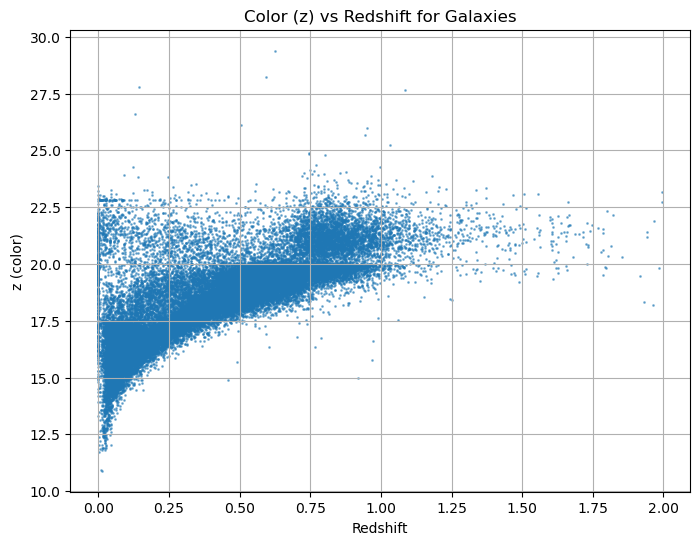

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    df_galaxies_selected_clean['redshift'],
    df_galaxies_selected_clean['z'],
    s=1, alpha=0.5
)
plt.xlabel('Redshift')
plt.ylabel('z (color)')
plt.title('Color (z) vs Redshift for Galaxies')
plt.grid(True)
plt.show()

In [6]:
df_galaxies_selected_clean['u-g'] = df_galaxies_selected_clean['u'] - df_galaxies_selected_clean['g']
df_galaxies_selected_clean['g-r'] = df_galaxies_selected_clean['g'] - df_galaxies_selected_clean['r']
df_galaxies_selected_clean['r-i'] = df_galaxies_selected_clean['r'] - df_galaxies_selected_clean['i']
df_galaxies_selected_clean['i-z'] = df_galaxies_selected_clean['i'] - df_galaxies_selected_clean['z']

df_galaxies_selected_clean[['u-g', 'g-r', 'r-i', 'i-z']].head()

,u-g,g-r,r-i,i-z
0,1.60352,1.88029,1.22928,0.37202
1,1.94571,0.24744,1.41632,-0.44615
2,2.59918,2.05413,1.26119,0.40030
3,-1.63974,2.16494,1.10708,1.25444
4,1.85690,1.08281,0.52036,0.43250


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
mag_cols = ['u', 'g', 'r', 'i', 'z', 'u-g', 'g-r', 'r-i', 'i-z']
df_galaxies_selected_clean[[f'{col}_scaled' for col in mag_cols]] = scaler.fit_transform(df_galaxies_selected_clean[mag_cols])
df_galaxies_selected_clean[[f'{col}_scaled' for col in mag_cols]].head()

,u_scaled,g_scaled,r_scaled,i_scaled,z_scaled,u-g_scaled,g-r_scaled,r-i_scaled,i-z_scaled
0,0.570312,0.649720,0.431167,0.186343,0.208821,-0.063243,0.899294,1.249982,-0.089434
1,0.967169,0.913763,1.599408,1.371628,1.912335,0.214361,-1.715904,1.723967,-2.453839
2,1.181536,0.834068,0.545754,0.294573,0.302170,0.744493,1.177719,1.330847,-0.007708
3,-0.198878,1.361922,1.080329,0.978832,0.484464,-2.694359,1.355194,0.940311,2.460646
4,-1.390920,-1.577610,-1.648491,-1.701112,-1.753516,0.142313,-0.377962,-0.546517,0.085346


In [8]:
df_galaxies_selected_clean.head()

,u,g,r,i,z,redshift,u-g,g-r,r-i,i-z,u_scaled,g_scaled,r_scaled,i_scaled,z_scaled,u-g_scaled,g-r_scaled,r-i_scaled,i-z_scaled
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,1.60352,1.88029,1.22928,0.37202,0.570312,0.649720,0.431167,0.186343,0.208821,-0.063243,0.899294,1.249982,-0.089434
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,1.94571,0.24744,1.41632,-0.44615,0.967169,0.913763,1.599408,1.371628,1.912335,0.214361,-1.715904,1.723967,-2.453839
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,2.59918,2.05413,1.26119,0.40030,1.181536,0.834068,0.545754,0.294573,0.302170,0.744493,1.177719,1.330847,-0.007708
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,-1.63974,2.16494,1.10708,1.25444,-0.198878,1.361922,1.080329,0.978832,0.484464,-2.694359,1.355194,0.940311,2.460646
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,1.85690,1.08281,0.52036,0.43250,-1.390920,-1.577610,-1.648491,-1.701112,-1.753516,0.142313,-0.377962,-0.546517,0.085346


### Bayesian model training:

In [9]:
import pymc as pm
import numpy as np

In [10]:
print(f"{len(df)}")

100000


In [11]:
from sklearn.model_selection import train_test_split

feature_cols = [f"{col}_scaled" for col in mag_cols]
df_sample = df_galaxies_selected_clean.sample(n=1000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    df_sample[feature_cols].values,
    df_sample['redshift'].values,
    test_size=0.2,
    random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (800, 9), Test shape: (200, 9)


In [12]:

n_features = X_train.shape[1]

with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sigma=1, shape=(n_features,))
    intercept = pm.Normal("intercept", mu=0, sigma=1)

    mu_z = intercept + pm.math.dot(X_train, beta)

    sigma = pm.HalfNormal("sigma", sigma=1)

    z_obs = pm.Normal("z_obs", mu=mu_z, sigma=sigma, observed=y_train)

    trace = pm.sample(1000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 652 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [13]:
import arviz as az

summary = az.summary(trace)
print(summary)

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]    0.048  0.805  -1.424    1.593      0.019    0.014    1736.0   
beta[1]    0.067  0.884  -1.572    1.707      0.020    0.014    1983.0   
beta[2]    0.046  0.858  -1.656    1.585      0.018    0.013    2299.0   
beta[3]    0.046  0.826  -1.466    1.659      0.019    0.013    1892.0   
beta[4]    0.000  0.823  -1.518    1.540      0.021    0.015    1470.0   
beta[5]   -0.024  0.438  -0.858    0.783      0.011    0.007    1735.0   
beta[6]   -0.043  0.297  -0.586    0.535      0.008    0.005    1517.0   
beta[7]    0.058  0.211  -0.363    0.429      0.006    0.004    1365.0   
beta[8]    0.021  0.172  -0.301    0.338      0.005    0.003    1464.0   
intercept  0.425  0.004   0.417    0.434      0.000    0.000    4706.0   
sigma      0.124  0.003   0.118    0.129      0.000    0.000    4152.0   

           ess_tail  r_hat  
beta[0]      2297.0   1.00  
beta[1]      2114.0   1.00  
beta[2]      2492.0   1.

### Results analysis


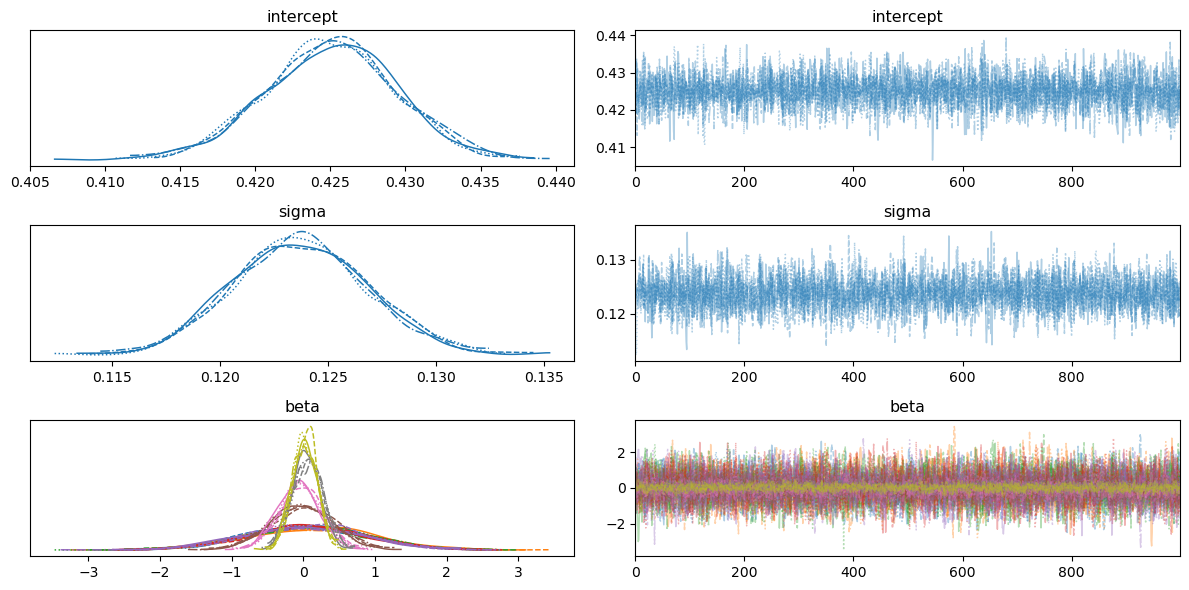

In [14]:
az.plot_trace(trace, var_names=["intercept", "sigma", "beta"])
plt.tight_layout()
plt.show()

In [15]:
posterior_pred_test = (
    trace.posterior['intercept'].values[..., None] +
    np.tensordot(trace.posterior['beta'].values, X_test.T, axes=([2],[0]))
)  

z_pred_mean_test = posterior_pred_test.mean(axis=(0,1))
z_pred_hdi_test = np.percentile(posterior_pred_test, [2.5, 97.5], axis=(0,1))


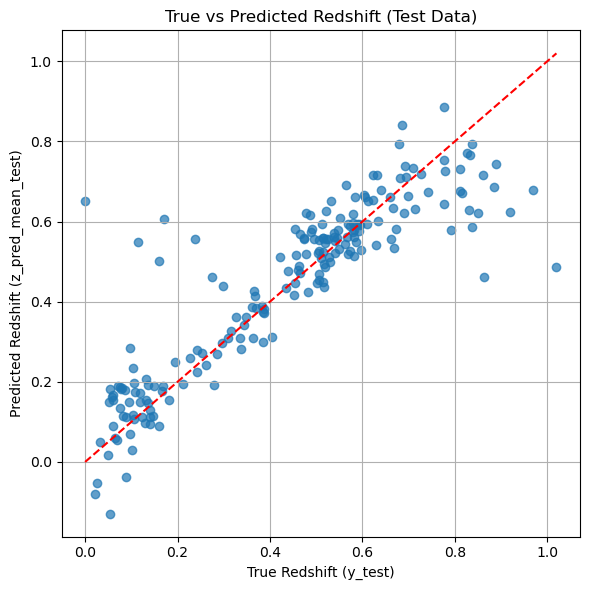

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, z_pred_mean_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Redshift (y_test)')
plt.ylabel('Predicted Redshift (z_pred_mean_test)')
plt.title('True vs Predicted Redshift (Test Data)')
plt.grid(True)
plt.tight_layout()
plt.show()

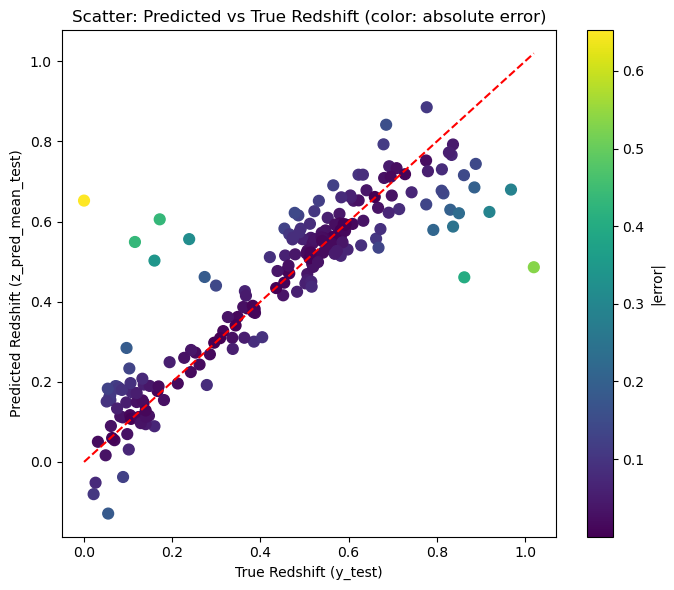

In [17]:
abs_error = np.abs(z_pred_mean_test - y_test)
plt.figure(figsize=(7, 6))
sc = plt.scatter(y_test, z_pred_mean_test, c=abs_error, cmap='viridis', s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Redshift (y_test)')
plt.ylabel('Predicted Redshift (z_pred_mean_test)')
plt.title('Scatter: Predicted vs True Redshift (color: absolute error)')
plt.colorbar(sc, label='|error|')
plt.tight_layout()
plt.show()

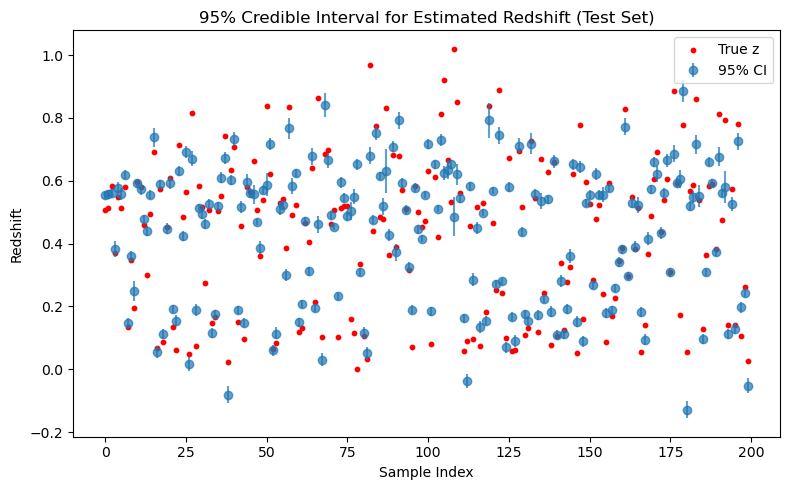

In [18]:
plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(len(y_test)), z_pred_mean_test, 
             yerr=[z_pred_mean_test - z_pred_hdi_test[0], z_pred_hdi_test[1] - z_pred_mean_test], 
             fmt='o', label='95% CI', alpha=0.7)
plt.scatter(np.arange(len(y_test)), y_test, color='r', s=10, label='True z')
plt.xlabel('Sample Index')
plt.ylabel('Redshift')
plt.title('95% Credible Interval for Estimated Redshift (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()

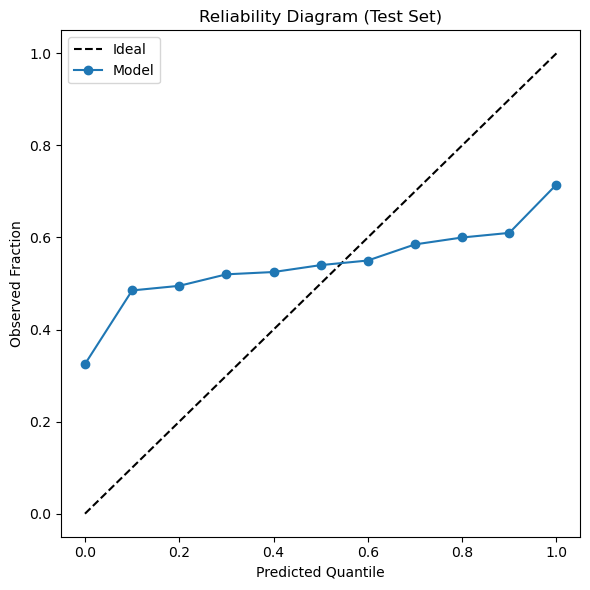

In [19]:
quantiles = np.linspace(0, 1, 11)
pred_q = np.quantile(posterior_pred_test, quantiles, axis=(0,1))
obs_q = np.quantile(y_test, quantiles)

plt.figure(figsize=(6, 6))
plt.plot(quantiles, quantiles, 'k--', label='Ideal')
plt.plot(quantiles, [np.mean(y_test <= pq) for pq in pred_q], 'o-', label='Model')
plt.xlabel('Predicted Quantile')
plt.ylabel('Observed Fraction')
plt.title('Reliability Diagram (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, z_pred_mean_test))
mae = mean_absolute_error(y_test, z_pred_mean_test)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.1174
MAE: 0.0739


import seaborn as sns
import arviz as az

c:\Users\Carlos\miniconda3\envs\lsst-discovery\lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


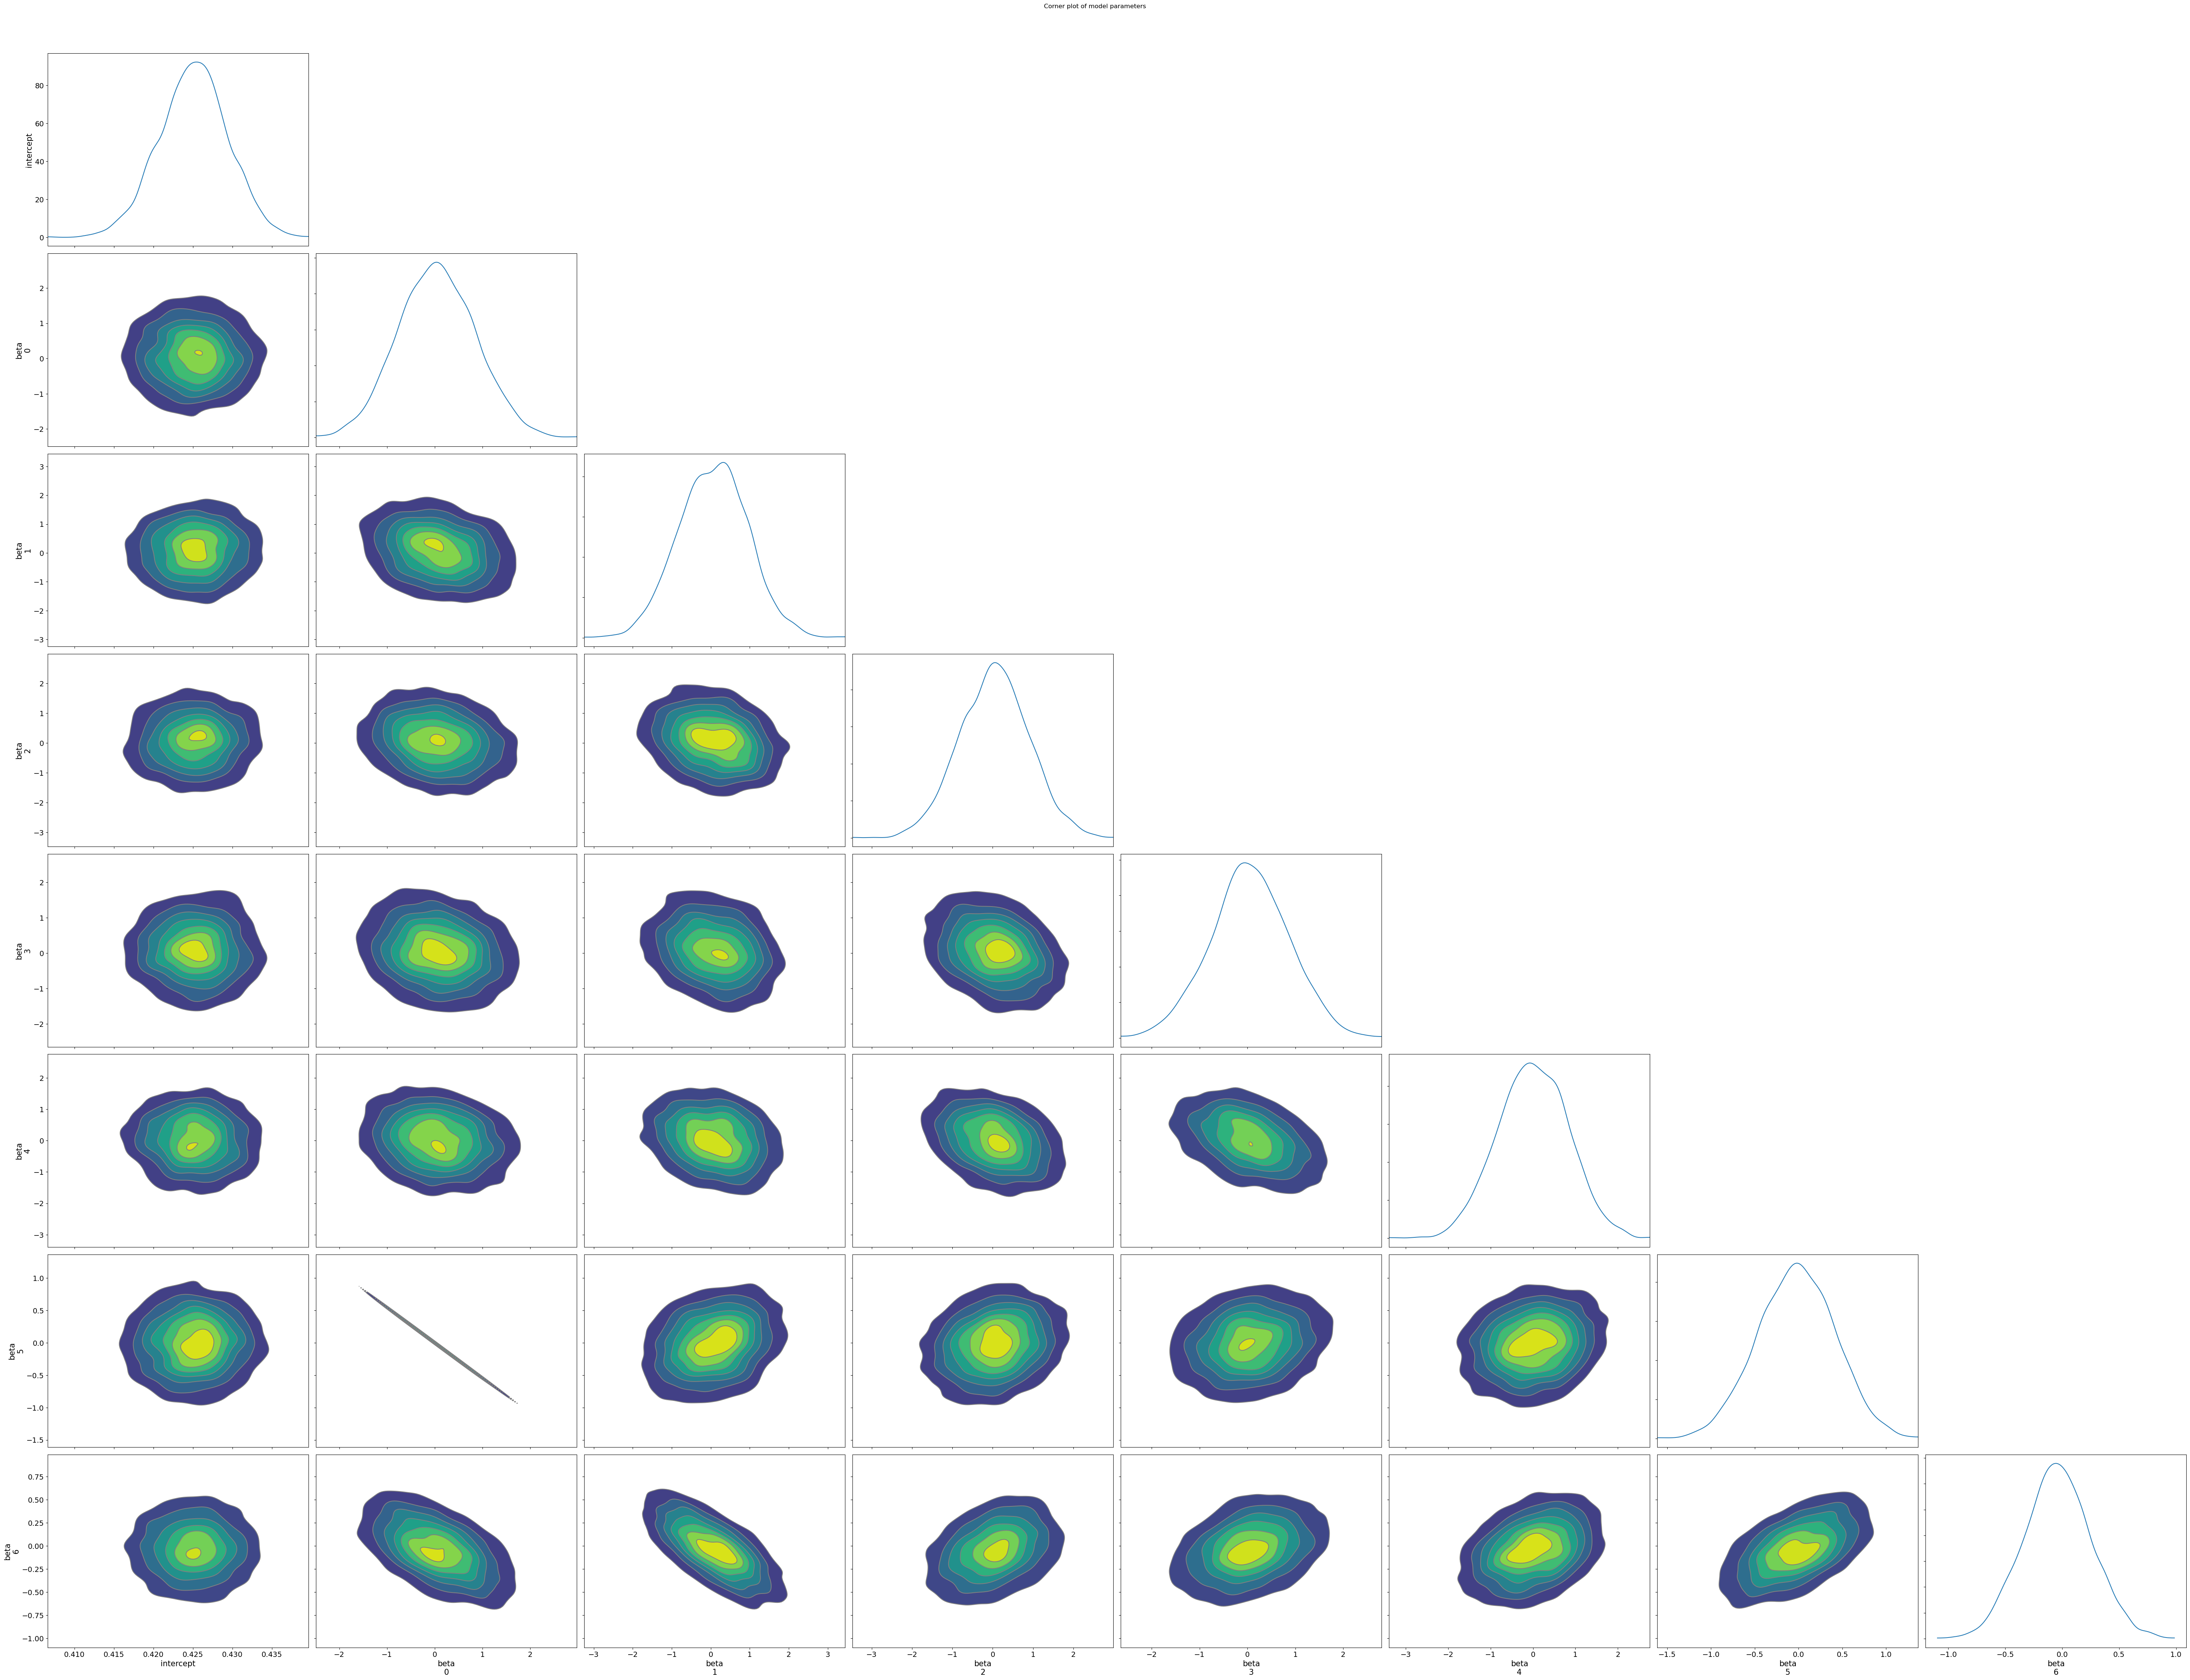

In [21]:
az.plot_pair(trace, var_names=["intercept", "beta"], kind='kde', marginals=True)
plt.suptitle("Corner plot of model parameters", y=1.02)
plt.tight_layout()
plt.show()

### Conclusions

Based on the results obtained, it is possible to estimate the redshift in the simulated LSST data using the different generated bands. In this work, data from SDSS 17 were used with a small sample of 1000 objects, of which 80% were used for training and the remainder for testing. The results were satisfactory, showing low error rates and only a few estimates with very high errors.